In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

## Open data and create X, y

In [3]:
datadir = '../data/'

In [4]:
ds_train = xr.open_dataset(f'{datadir}autocon_train_big.nc')
ds_test = xr.open_dataset(f'{datadir}autocon_test_big.nc')

In [55]:
# I just modified this to return accretion and autoconversion (copied from accnorm_v4)
def read_and_prepare_data(fname,auto_sml):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values
    
    acc  = xr.open_dataset(fname).accr_norm.values
    
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    
    acc_min = 7e-10
    
    # introduce small but non-zero value for autoconversion into the dataset
    # (this can maybe called "data augmentation", because in that way we keep more data by adding artificial "labels")
    if auto_sml > 0:
        if (auto_sml < 1):
            # small but constant value
            auto = np.where( (Lc > 1e-5) & (auto < auto_sml) & (tau < 0.1),auto_sml,auto)
        else:
            # use autoconversion based on Long kernel. This gives our augmented data the proper scaling
            kcc = 9.44e9     # Long kernel in m3 kg-2 s-1 
            xstar = 2.6e-10    # xstar in kg
            auLg = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * Lc**2 * (Lc/(Nc+N_min))**2
            auto = np.where( (Lc > 1e-5) & (auto < auLg) & (tau < 0.1),auLg,auto)
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    autoL2 = np.log(autoL2, where=autoL2>auto_min, out=np.nan*autoL2)
    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [acc.ravel(), auto.ravel(), autoL2.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), tau.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc', 'auto','autoL2','Lc','Xc','Lr','tau','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [56]:
df_train = read_and_prepare_data(f'{datadir}autocon_train_big.nc', 0)
df_test = read_and_prepare_data(f'{datadir}autocon_test_big.nc', 0)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: inval

In [57]:
len(df_train), len(df_test)

(245702, 160288)

In [58]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
    dataset.drop(idx,inplace=True)
    idx = dataset[ dataset['Lc'] < np.log(0.02e-3) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [59]:
df_train  = reduce_data(df_train)
df_test = reduce_data(df_test)

In [60]:
len(df_train), len(df_test)

(222994, 141998)

In [61]:
df_train.head()

acc       auto     autoL2       Lc         Xc         Lr        tau  \
124 -2.115741 -33.946274 -16.901932 -8.52217 -26.494270 -30.329424 -21.807255   
126 -1.205110 -33.679760 -16.635418 -8.52217 -26.493734 -29.784315 -21.262146   
135 -1.045592 -31.890795 -14.846454 -8.52217 -26.492180 -28.466280 -19.944111   
138 -1.391895 -34.406319 -17.361979 -8.52217 -26.491583 -28.379604 -19.857435   
141 -0.579458 -34.385334 -17.340994 -8.52217 -26.491323 -28.282745 -19.760576   

      nu  
124  0.0  
126  0.0  
135  0.0  
138  0.0  
141  0.0

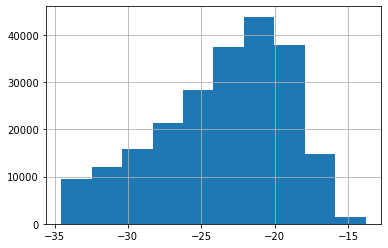

In [12]:
df_train.auto.hist()

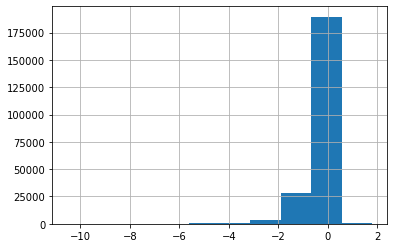

In [63]:
df_train.acc.hist()

One thing I notice here is that autoconversion and accretion have quite different values. So if we want to predict both at the same time, we probably should rescale them. We will come back to this later.

In [131]:
# Take all the inputs
Xtrain = df_train[['Lc', 'Xc', 'Lr', 'tau', 'nu']]
ytrain_auto = df_train['auto']
ytrain_acc = df_train['acc']
ytrain_both = df_train[['auto', 'acc']]
Xtest = df_test[['Lc', 'Xc', 'Lr', 'tau', 'nu']]
ytest_auto = df_test['auto']
ytest_acc = df_test['acc']
ytest_both = df_test[['auto', 'acc']]

In [132]:
# Normalize
mean = Xtrain.mean()
std = Xtrain.std()

In [133]:
mean, std

(Lc     -8.006601
 Xc    -25.781155
 Lr    -13.657567
 tau    -5.869234
 nu      2.092316
 dtype: float32,
 Lc     0.770026
 Xc     0.495176
 Lr     5.017296
 tau    5.001824
 nu     1.380270
 dtype: float32)

In [134]:
Xtrain = (Xtrain - mean) / std
Xtest = (Xtest - mean) / std

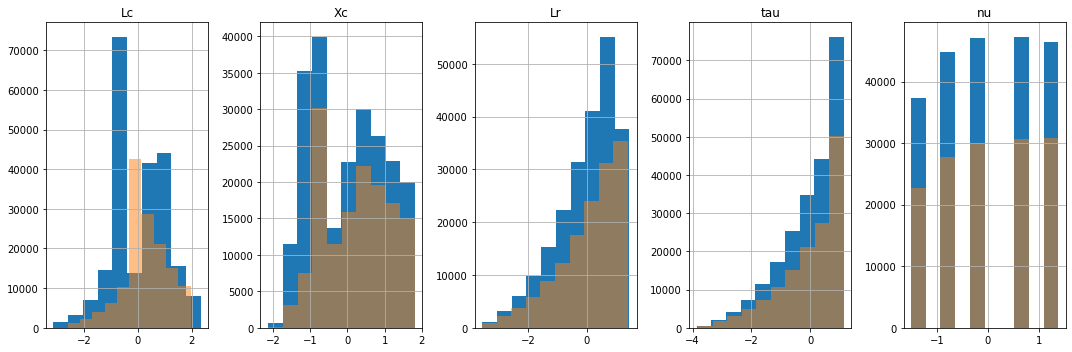

In [135]:
# Just checking if there is enough overlap between training and testing
fig, axs = plt.subplots(1, len(Xtrain.columns), figsize=(15, 5))
for ax, c in zip(axs, Xtrain.columns):
    Xtrain[c].hist(ax=ax)
    Xtest[c].hist(ax=ax, alpha=0.5)
    ax.set_title(c)
plt.tight_layout()

## Random forest

Let's train a random forest, which is basically just a ensemble of decision trees.

In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [137]:
# Start with autocon
rf_auto = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)

In [138]:
rf_auto.fit(Xtrain, ytrain_auto)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=20, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [139]:
# This is the R2 score = explained variance
# Shows quite a bit of overfitting but that's kind of unavoidable with a RF.
rf_auto.score(Xtrain, ytrain_auto), rf_auto.score(Xtest, ytest_auto)

(0.8995363269160734, 0.8323829084555031)

In [140]:
preds = rf_auto.predict(Xtest)

In [141]:
# Quite a bit worse than your best NNs, which have a score of around 1.09
mean_absolute_error(ytest_auto, preds)

1.2280043526710582

### Now the same for accretion and both at the same time

In [142]:
rf_acc = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)
rf_acc.fit(Xtrain, ytrain_acc)
print(rf_acc.score(Xtrain, ytrain_acc), rf_acc.score(Xtest, ytest_acc))
preds = rf_acc.predict(Xtest)
mean_absolute_error(ytest_acc, preds)   # Comprated to 0.12 from accnorm_v4

0.6626914845960463 0.3784230521327968


0.18078082462707099

In [143]:
ytrain_both.std()   # Since they have different stds but are equally important we need to rescale the values

auto    4.442519
acc     0.554403
dtype: float32

In [144]:
ytrain_both.loc[:, 'auto'] = ytrain_both['auto'] / 10   # For now this should get them to the same order

/home/rasp/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [145]:
ytrain_both.std()   # Since they have different stds but are equally important we need to rescale the values

auto    0.444251
acc     0.554403
dtype: float32

In [146]:
rf_both = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)
rf_both.fit(Xtrain, ytrain_both)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=20, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [147]:
# To make the scores comparable we have to scale them back to their original values
preds = rf_both.predict(Xtest)
preds.shape

(141998, 2)

In [148]:
mean_absolute_error(ytest_auto, preds[:, 0]*10)  # Actually a little better than the rf that only predicts auto

1.1845565496769153

In [149]:
mean_absolute_error(ytest_acc, preds[:, 1])

0.18368667163479266

### Feature importance

One interesting thing we can do with a random forest (actually a NN as well) is to check which input feature is most important. The plots below show how much each feature contributes to the final score. Bigger values = more important.

Maybe you can check whether this fits your intuition of the problem.

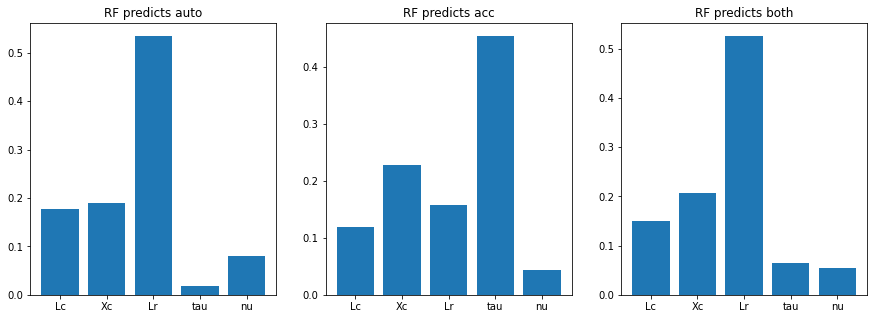

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(Xtrain.columns, rf_auto.feature_importances_); ax1.set_title('RF predicts auto')
ax2.bar(Xtrain.columns, rf_acc.feature_importances_); ax2.set_title('RF predicts acc')
ax3.bar(Xtrain.columns, rf_both.feature_importances_); ax3.set_title('RF predicts both');

In [151]:
# Just a different way of computing this
# But basically same results
from sklearn.inspection import permutation_importance

In [152]:
r = permutation_importance(rf, Xtest, ytest)

<BarContainer object of 5 artists>

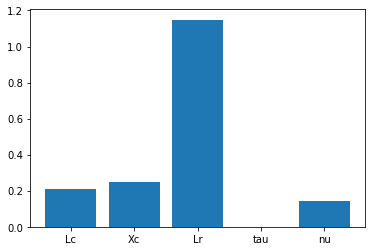

In [153]:
plt.bar(Xtrain.columns, r.importances_mean)

### Partial dependence plot

These plots show how the output of the model changes as the input changes. The way this is computed is by picking a column=feature, e.g. Lc, setting all the rows in this column to one value and then making a prediction. By progressively increasing the value, one can check how the output changes. Then do this for all columns.

BTW, we can also do all these interpretation methods for NNs later.

Again, do the results make physical sense?

In [154]:
from sklearn.inspection import plot_partial_dependence

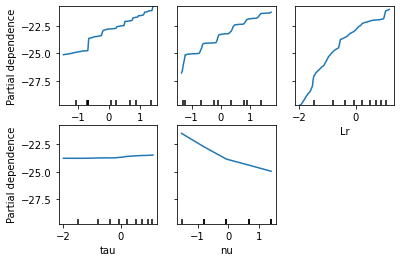

In [164]:
# Auto RF
# Unfortunately, the x label is covered. The first two plots are Lc and Xc
plot_partial_dependence(rf_auto, Xtrain[::100], range(len(Xtrain.columns)), n_jobs=20);

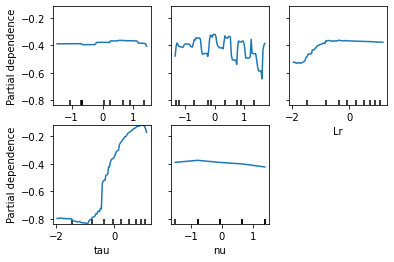

In [161]:
# Acc RF
plot_partial_dependence(rf_acc, Xtrain[::100], range(len(Xtrain.columns)), n_jobs=20);

## Neural network

Ok, now let's tackle neural networks. First, I'll build a very similar network to the one's you built and try to reproduce the scores. Let's start with autoconversion.

In [167]:
from tensorflow.keras.layers import *

In [182]:
model = keras.Sequential([
    Dense(16, input_shape=(5,), activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1),
])

In [183]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [184]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [185]:
model.fit(Xtrain, ytrain_auto, epochs=15, batch_size=256, validation_data=(Xtest, ytest_auto))

Train on 222994 samples, validate on 141998 samples
Epoch 1/15
222994/222994 [==============================] - 4s 18us/sample - loss: 11.1086 - val_loss: 3.3199
Epoch 2/15
222994/222994 [==============================] - 4s 16us/sample - loss: 2.5207 - val_loss: 1.4772
Epoch 3/15
222994/222994 [==============================] - 4s 16us/sample - loss: 1.5644 - val_loss: 1.1855
Epoch 4/15
222994/222994 [==============================] - 3s 16us/sample - loss: 1.3694 - val_loss: 1.1204
Epoch 5/15
222994/222994 [==============================] - 3s 15us/sample - loss: 1.3273 - val_loss: 1.1016
Epoch 6/15
222994/222994 [==============================] - 3s 15us/sample - loss: 1.3179 - val_loss: 1.0911
Epoch 7/15
222994/222994 [==============================] - 3s 16us/sample - loss: 1.3145 - val_loss: 1.0912
Epoch 8/15
222994/222994 [==============================] - 3s 15us/sample - loss: 1.3128 - val_loss: 1.0887
Epoch 9/15
222994/222994 [==============================] - 3s 15us/sample 

So this is about what you got in your notebook. Next, let's try to create a really big net and see if we can get better or overfit.

In [197]:
model = keras.Sequential([
    Dense(256, input_shape=(5,), activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(1),
])

In [219]:
inp = x = Input((5,))
x = Dense(512, activation='relu')(x)
for _ in range(6):
    skip = x
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Add()([skip, x])
outp = Dense(1)(x)
model = keras.models.Model(inp, outp)

In [220]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 512)          3072        input_7[0][0]                    
__________________________________________________________________________________________________
dense_104 (Dense)               (None, 512)          262656      dense_103[0][0]                  
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 512)          262656      dense_104[0][0]                  
____________________________________________________________________________________________

In [221]:
model.compile(tf.keras.optimizers.Adam(1e-4), 'mae')

In [222]:
model.fit(Xtrain, ytrain_auto/10, epochs=15, batch_size=256, validation_data=(Xtest, ytest_auto/10))

Train on 222994 samples, validate on 141998 samples
Epoch 1/15
222994/222994 [==============================] - 6s 29us/sample - loss: 0.1834 - val_loss: 0.1256
Epoch 2/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1371 - val_loss: 0.1149
Epoch 3/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1358 - val_loss: 0.1267
Epoch 4/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1345 - val_loss: 0.1172
Epoch 5/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1339 - val_loss: 0.1114
Epoch 6/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1329 - val_loss: 0.1104
Epoch 7/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1327 - val_loss: 0.1093
Epoch 8/15
222994/222994 [==============================] - 6s 25us/sample - loss: 0.1324 - val_loss: 0.1123
Epoch 9/15
222994/222994 [==============================] - 6s 25us/sample -

In [216]:
len(Xtrain)

222994

I tried several NN architectures and hyperparameters and was unable to make the model overfit. This is kind of curious. Usually, by increasing the network size, one should be able to at least get lower training scores but this is not the case here. What this suggests to me is that the training data is constructed in a way that doesn't allow the NN to overfit, i.e. memorize the data. So I think the small network pretty much is already the best possible network.

### For accretion

In [223]:
model = keras.Sequential([
    Dense(16, input_shape=(5,), activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1),
])

In [224]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 16)                96        
_________________________________________________________________
dense_118 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_119 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [225]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [226]:
model.fit(Xtrain, ytrain_acc, epochs=15, batch_size=256, validation_data=(Xtest, ytest_acc))

Train on 222994 samples, validate on 141998 samples
Epoch 1/15
222994/222994 [==============================] - 4s 17us/sample - loss: 0.2189 - val_loss: 0.1821
Epoch 2/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.2046 - val_loss: 0.1790
Epoch 3/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.2023 - val_loss: 0.1783
Epoch 4/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.2012 - val_loss: 0.1756
Epoch 5/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.2007 - val_loss: 0.1742
Epoch 6/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.2002 - val_loss: 0.1751
Epoch 7/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.1999 - val_loss: 0.1741
Epoch 8/15
222994/222994 [==============================] - 3s 15us/sample - loss: 0.1999 - val_loss: 0.1748
Epoch 9/15
222994/222994 [==============================] - 3s 15us/sample -

In fact, I seem to get slightly worse values compared to your notebook. I still need to investigate why.

### Predict both

In [236]:
model = keras.Sequential([
    Dense(128, input_shape=(5,), activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(2),
])

In [237]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_126 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_127 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 258       
Total params: 34,050
Trainable params: 34,050
Non-trainable params: 0
_________________________________________________________________


In [238]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [239]:
model.fit(Xtrain, ytrain_both, epochs=15, batch_size=256)

Train on 222994 samples
Epoch 1/15
222994/222994 [==============================] - 3s 13us/sample - loss: 0.2054
Epoch 2/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1712
Epoch 3/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1690
Epoch 4/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1685
Epoch 5/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1679
Epoch 6/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1675
Epoch 7/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1670
Epoch 8/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1667
Epoch 9/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1668
Epoch 10/15
222994/222994 [==============================] - 2s 11us/sample - loss: 0.1665
Epoch 11/15
222994/222994 [==============================] - 2s 11us/sample

In [240]:
preds = model.predict(Xtest)

In [241]:
preds = model.predict(Xtest)
preds.shape

(141998, 2)

In [242]:
mean_absolute_error(ytest_auto, preds[:, 0]*10) 

1.1316696

In [243]:
mean_absolute_error(ytest_acc, preds[:, 1])

0.172658

Not better for the NN case. So all this leaves me to conclude that small networks are absolutely sufficient for the dataset and, in terms of netowrk architectures, you alread got the most out of the data!